0.07196000814437867 0.005390593019230106


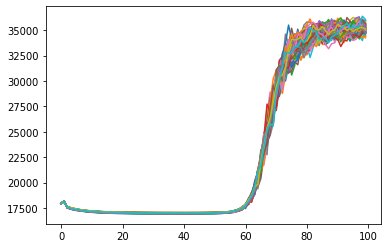

In [8]:
import numpy as np
import scipy
import argparse
import sys
import os
import time
import scipy.linalg
import matplotlib.pyplot as plt

def fOde(theta, x, k):
    """
    theta: list[2]: 
    """
    global Tt
    logX = x[:, 0]
    logXdt = 1e5 * theta[:, 0] * np.exp(-logX) + 1e3 * theta[:, 1] * Tt[k] * np.exp(-logX) - 3.5
    return np.stack([logXdt], axis=1)

def find_all_sigma_points(x_bar, x_var, alpha=1e-3, kappa=0, beta=2):
    l_dim_x = len(x_bar)
    lambda_scaling = alpha**2 * (l_dim_x + kappa) - l_dim_x
    eigval, eigmat = np.linalg.eig((l_dim_x + lambda_scaling) * x_var)
    matsqrt = eigmat @ np.diag(np.sqrt(eigval)) @ eigmat.transpose()
    sigma_points = np.block([
        [x_bar],
        [x_bar + matsqrt],
        [x_bar - matsqrt]])
    weight_m = np.ones(2*l_dim_x+1) / (2 * (l_dim_x + lambda_scaling))
    weight_m[0] = lambda_scaling / (l_dim_x + lambda_scaling)
    weight_c = np.copy(weight_m)
    weight_c[0] = lambda_scaling / (l_dim_x + lambda_scaling) + (1 - alpha**2 + beta)
    return dict(sigma_points=sigma_points, weight_m=weight_m, weight_c=weight_c)

ukf_ls = np.zeros((100, 100, 6))

days = 100
obs_per_day = 1
time_ls = np.zeros(100)
for EachRep in range(100):
    start_time = time.time()
    SEED = np.random.randint(1, 100000)
    np.random.seed(SEED)
    yobs = np.load('G:/HIV observations.npy')[EachRep][:, 0].reshape(-1, 1)
    Tt = np.load('G:/HIV observations.npy')[EachRep][:, 1]
    ydata = yobs.copy()
    tvecObs = np.arange(0, days, 1/obs_per_day)
    tvecFull = np.arange(0, days, 1 / obs_per_day)
    yFull = ydata.copy()
    xInitExogenous = np.zeros_like(yFull)
    for j in range(ydata.shape[1]):
        xInitExogenous[:, j] = np.interp(tvecFull, tvecObs, ydata[:, j])
        
        
    noise = 0.2
    dim_x = 1
    dim_theta = 2
    prior_mean_x_theta_u_e = np.array([yFull[0, 0], 0.18, -0.05, 0,0,0])
    prior_variance_x_theta = np.diag([noise ** 2, 1, 1])
    variance_u_unit_time = np.diag([0.001, 0.001])
    prior_variance_e = np.diag([noise ** 2])

    estimate_x_theta_u_e = np.zeros(shape=[yFull.shape[0], dim_x + dim_theta + dim_theta + dim_x])
    variance_x_theta_u_e = np.zeros(shape=[yFull.shape[0], dim_x + dim_theta + dim_theta + dim_x, dim_x + dim_theta + dim_theta + dim_x])

    estimate_x_theta_u_e[0] = prior_mean_x_theta_u_e
    variance_x_theta_u_e[0] = scipy.linalg.block_diag(prior_variance_x_theta, variance_u_unit_time, prior_variance_e)
    for k in range(1, yFull.shape[0]):
        delta_t = tvecFull[k] - tvecFull[k-1]
        variance_x_theta_u_e[k-1][(dim_x + dim_theta):(dim_x + 2 * dim_theta), (dim_x + dim_theta):(dim_x + 2 * dim_theta)] *= delta_t

        unscented_info = find_all_sigma_points(estimate_x_theta_u_e[k-1], variance_x_theta_u_e[k-1])

        sigma_points_pred_theta = unscented_info['sigma_points'][:, dim_x:(dim_x+dim_theta)] + unscented_info['sigma_points'][:, (dim_x+dim_theta):(dim_x+2*dim_theta)]
        sigma_points_previous_x = unscented_info['sigma_points'][:, :dim_x]
        sigma_points_pred_x = sigma_points_previous_x + delta_t * fOde(sigma_points_pred_theta, sigma_points_previous_x, k)

        mean_pred_x = np.sum(sigma_points_pred_x * unscented_info['weight_m'].reshape([-1, 1]), axis=0)
        mean_pred_theta = np.sum(sigma_points_pred_theta * unscented_info['weight_m'].reshape([-1, 1]), axis=0)

        mean_pred_x_theta = np.concatenate([mean_pred_x, mean_pred_theta])
        sigma_points_pred_x_theta = np.block([sigma_points_pred_x, sigma_points_pred_theta])
        var_pred_x_theta = np.zeros([dim_x + dim_theta, dim_x + dim_theta])
        for i in range(sigma_points_pred_x_theta.shape[0]):
            residual = sigma_points_pred_x_theta[i, :] - mean_pred_x_theta
            var_pred_x_theta += unscented_info['weight_c'][i] * residual.reshape([-1, 1]) @ residual.reshape([1, -1])

        sigma_points_pred_u_e =  unscented_info['sigma_points'][:, (dim_x+dim_theta):]
        mean_pred_u_e = np.sum(sigma_points_pred_u_e * unscented_info['weight_m'].reshape([-1, 1]), axis=0)
        var_pred_u_e = np.zeros([dim_x + dim_theta, dim_x + dim_theta])
        for i in range(sigma_points_pred_u_e.shape[0]):
            residual = sigma_points_pred_u_e[i, :] - mean_pred_u_e
            var_pred_u_e += unscented_info['weight_c'][i] * residual.reshape([-1, 1]) @ residual.reshape([1, -1])
        sigma_points_pred = np.block([sigma_points_pred_x_theta, sigma_points_pred_u_e])
        mean_pred = np.sum(sigma_points_pred * unscented_info['weight_m'].reshape([-1, 1]), axis=0)
        var_pred = np.zeros([2 * (dim_x + dim_theta), 2 * (dim_x + dim_theta)])
        for i in range(sigma_points_pred.shape[0]):
            residual = sigma_points_pred[i, :] - mean_pred
            var_pred += unscented_info['weight_c'][i] * residual.reshape([-1, 1]) @ residual.reshape([1, -1])


        if not np.any(np.isfinite(yFull[k, :])):
            estimate_x_theta_u_e[k] = np.concatenate([mean_pred_x_theta, mean_pred_u_e])
            variance_x_theta_u_e[k] = scipy.linalg.block_diag(var_pred_x_theta, variance_u_unit_time, prior_variance_e)
        else:
            yobs = yFull[k, :]
            sigma_points_pred_y = sigma_points_pred_x + unscented_info['sigma_points'][:, (dim_x + 2 * dim_theta):]
            mean_pred_y = np.sum(sigma_points_pred_y * unscented_info['weight_m'].reshape([-1, 1]), axis=0)

            var_pred_y = np.zeros([dim_x, dim_x])
            cov_pred_xtheta_y = np.zeros([dim_x + dim_theta, dim_x])
            for i in range(sigma_points_pred_y.shape[0]):
                residual_y = sigma_points_pred_y[i, :] - mean_pred_y
                residual_xtheta = sigma_points_pred_x_theta[i, :] - mean_pred_x_theta
                var_pred_y += unscented_info['weight_c'][i] * residual_y.reshape([-1, 1]) @ residual_y.reshape([1, -1])
                cov_pred_xtheta_y += unscented_info['weight_c'][i] * residual_xtheta.reshape([-1, 1]) @ residual_y.reshape([1, -1])

            idx_yobs = np.isfinite(yobs)
            yobs = yobs[idx_yobs]
            var_pred_y = var_pred_y[idx_yobs, :][:, idx_yobs]
            mean_pred_y = mean_pred_y[idx_yobs]
            cov_pred_xtheta_y = cov_pred_xtheta_y[:, idx_yobs]

            invvar_pred_y = np.linalg.inv(var_pred_y)

            mean_pred_x_theta = mean_pred_x_theta + cov_pred_xtheta_y @ invvar_pred_y @ (yobs - mean_pred_y)
            var_pred_x_theta = var_pred_x_theta - cov_pred_xtheta_y @ invvar_pred_y @ cov_pred_xtheta_y.transpose()

            estimate_x_theta_u_e[k] = np.concatenate([mean_pred_x_theta, mean_pred_u_e])
            variance_x_theta_u_e[k] = scipy.linalg.block_diag(var_pred_x_theta, variance_u_unit_time, prior_variance_e)
    ukf_ls[EachRep] = estimate_x_theta_u_e
    time_ls[EachRep] = time.time() - start_time

print(np.mean(time_ls), np.std(time_ls))


for i in range(100):
    plt.plot(1e5 * ukf_ls[i, :, 1] + 1e3 * ukf_ls[i, :, 2])

In [10]:
all_a1 = ukf_ls[:, :, 1]
all_a2 = ukf_ls[:, :, 2]

days = 100  
obs_per_day = 1
nobs = days * obs_per_day
linspace = 1000
X = np.arange(0, days, 1./(obs_per_day * linspace))
true_lambda = 36.
true_rho = 0.108 
k = 5e-4
true_gamma = np.cos(3.14 * X / 500)
true_delta = 0.1
N = 1000.
c = 3.5




def true_data(true_lambda, true_rho, true_gamma, true_delta, days, obs_per_day, state0=[350., 20., 1200.],N=N, k=k, c=c, linspace=1000, noise=True):
    """
    generate data using pre-set parameters 
    """
    # check input
    # [ S, E, I, D, cfr0]
    nobs = days
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.ones((days * linspace * obs_per_day, 3))
    state_ls[0] = state0.copy()
    for i in range(1, linspace * days * obs_per_day):
        index = i - 1
        state_ls[i][0] = state_ls[i - 1][0] + step_size * (true_lambda - true_rho * state_ls[i - 1][0] - k * (1-true_gamma[index]) * state_ls[i - 1][0] * state_ls[i - 1][2])
        state_ls[i][1] = state_ls[i - 1][1] + step_size * (k * (1-true_gamma[index]) * state_ls[i - 1][0] * state_ls[i - 1][2] - true_delta * state_ls[i - 1][1])
        state_ls[i][2] = state_ls[i - 1][2] + step_size * (N * true_delta * state_ls[i - 1][1] - c * state_ls[i - 1][2]) 
    states = state_ls[::obs_per_day * linspace]

    return states[:, 0], state_ls[:, 1], np.log(states[:, 2])


Tt, It, true_x = true_data(true_lambda, true_rho, true_gamma, true_delta, days, obs_per_day)
all_a = np.zeros((100, 100))
for i in range(100):
    all_a[i] = all_a1[i] * 1e5 + all_a2[i] * 1e3 * Tt
It_diff = np.zeros(100)
for i in range(100):
    It_diff[i] = (It[1000 * i + 1] - It[1000 * i]) * 1000
    
true_a = -N * It_diff + Tt * (N * k * (1-true_gamma[::1000]) * np.exp(true_x))


def recover_data(a1, a2, Tt, state0, linspace=100, days=100, obs_per_day=1, discretization=1, mode = 'Linear', hyper=None):
    """
    params: parameter: [re, pe, pi, pd]
    """
    # check input
    # [ S, E, I, D, cfr0]
    step_size = 1. / linspace
    state_ls = np.ones(days * linspace)
    state_ls[0] = state0
    x_initial = np.linspace(0, 1000, days)
    x_interp = np.linspace(0, 1000, days * linspace)
    Tt_interp = np.interp(x_interp, x_initial, Tt)
    if mode == 'Linear': 
        a1_interp = np.interp(x_interp, x_initial, a1)
        a2_interp = np.interp(x_interp, x_initial, a2)
        Tt_interp = np.interp(x_interp, x_initial, Tt)
       
    for i in range(1, linspace * days):
        index = i - 1
        state_ls[i] = state_ls[i - 1] + step_size * (
                    1e5 * a1_interp[index] * np.exp(-state_ls[i - 1]) + 1e3 * a2_interp[index] * Tt_interp[index] * np.exp(
                -state_ls[i - 1]) - 3.5)

    return state_ls[::linspace]

all_reconstructed_x = np.zeros((100, 100))
for i in range(100):
    print(i)
    all_reconstructed_x[i] = recover_data(all_a1[i], all_a2[i], Tt, np.log(1200))
    
all_reconstructed_x = all_reconstructed_x[~np.isnan(all_reconstructed_x).any(axis=1), :]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


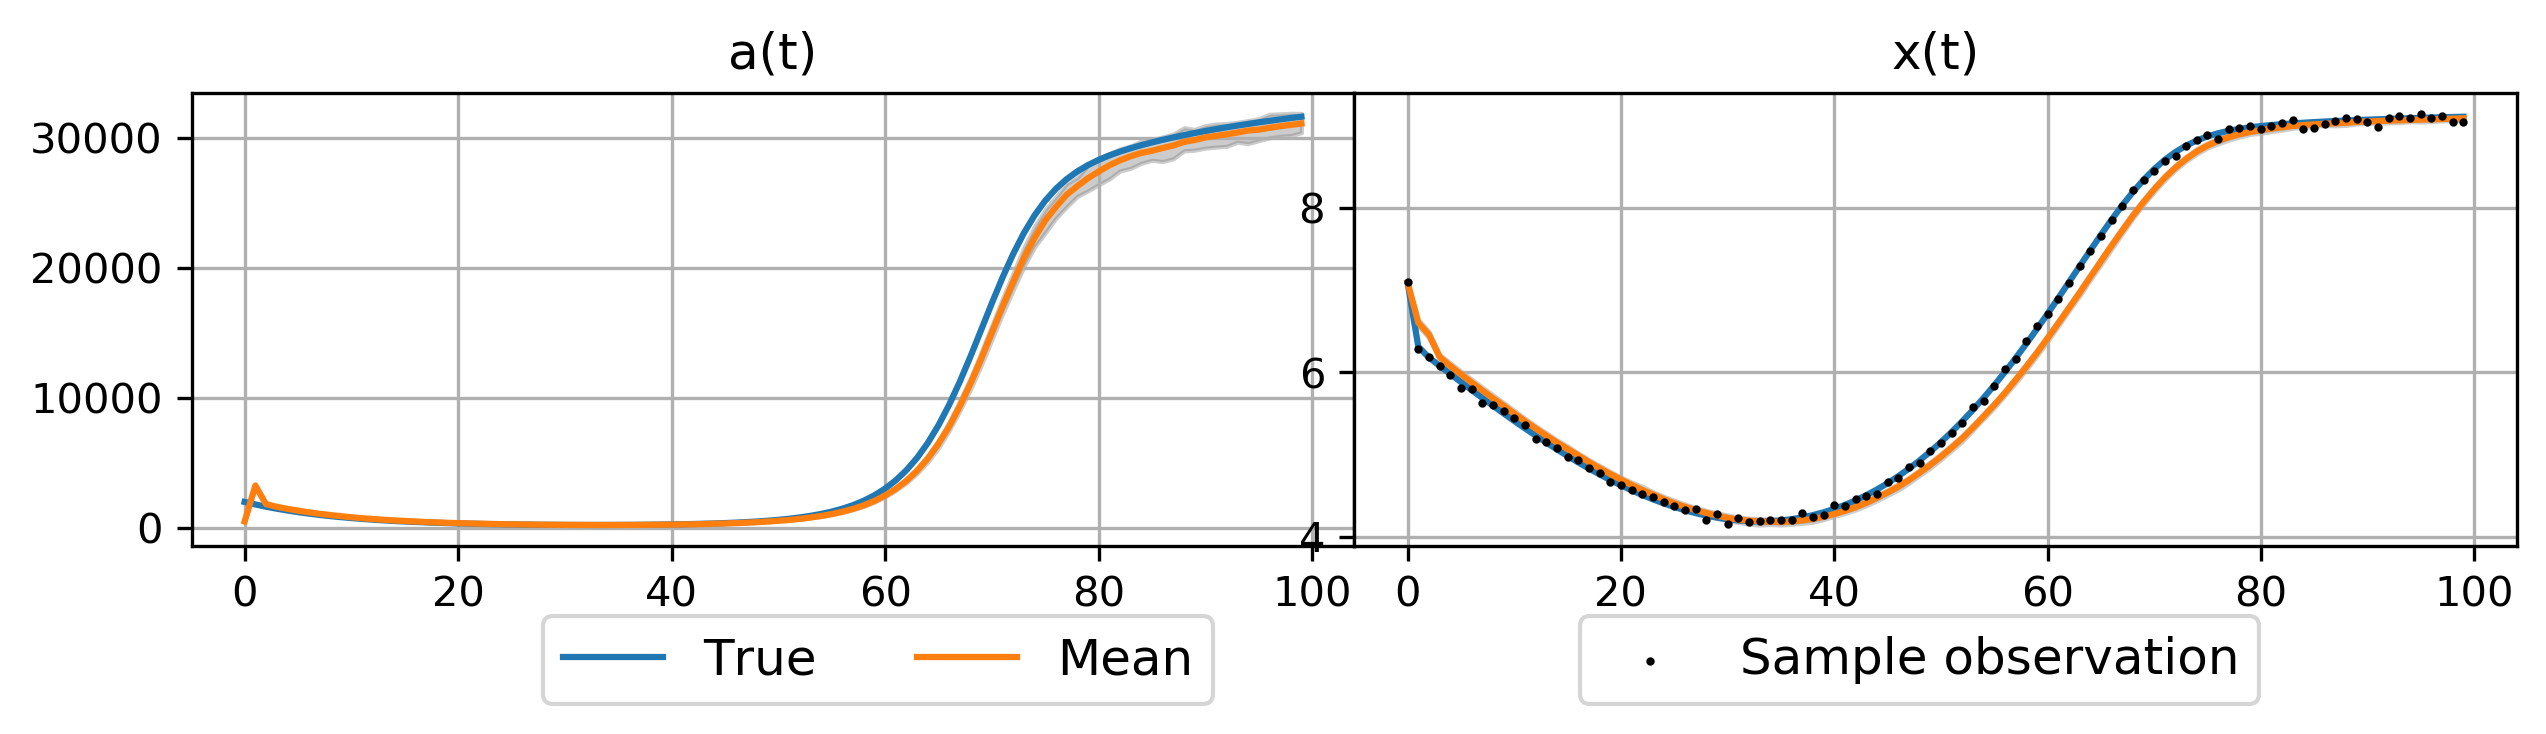

In [11]:
%matplotlib inline
import matplotlib # 注意这个也要import一次
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize # import figsize
#figsize(12.5, 4) # 设置 figsize
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率

figsize(10, 2)
plt.subplots_adjust(wspace =0, hspace =0)
ax1 = plt.subplot(1, 2, 1)
lower_95 = np.percentile(all_a, 97.5, axis=0)
upper_95 = np.percentile(all_a, 2.5, axis=0)
x = np.arange(0, days, 1 / obs_per_day)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(np.arange(0, days, 1 / obs_per_day), true_a, label='True')
plt.plot(x, np.mean(all_a, axis=0), label='Mean')
plt.grid()
plt.title('a(t)')
plt.legend(bbox_to_anchor=(0.9, -0.1), fontsize=12, ncol=4)


ax1 = plt.subplot(1, 2, 2)
yobs = np.load('G:/HIV observations.npy')[1]
lower_95 = np.percentile(all_reconstructed_x, 97.5, axis=0)
upper_95 = np.percentile(all_reconstructed_x, 2.5, axis=0)
x = np.arange(0, days, 1 / obs_per_day)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(np.arange(0, days, 1 / obs_per_day), true_x)
plt.plot(x, np.mean(all_reconstructed_x, axis=0))
plt.scatter(np.arange(0, days, 1 / obs_per_day), yobs[:, 0], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title('x(t)')
plt.legend(bbox_to_anchor=(0.8, -0.1), fontsize=12, ncol=4)

In [12]:
a_RMSE = np.zeros(100)
x_RMSE = np.zeros(100)
for i in range(all_reconstructed_x.shape[0]):
    x_RMSE[i] = np.sqrt(np.mean(np.square(true_x - all_reconstructed_x[i])))
    a_RMSE[i] = np.sqrt(np.mean(np.square(true_a - all_a[i])))

print(np.mean(a_RMSE), np.std(a_RMSE))    
print(np.mean(x_RMSE), np.std(x_RMSE))

828.4400921200867 49.068729343016784
0.14939050451990998 0.0029458193685961026
